## Seasonally Varying Parameters
This tutorial will walk through an example of including a seasonal parameter in an Epydemix model. As an example, we consider the case of a respiratory virus where the transmissiblity is believed to be higher during the winter and lower during the summer, but this could in theory be applied to any parameter which is believed to change throughout the year.

First, we import the required functions

In [11]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from flumodelingsuite.seasonality import get_seasonal_transmission_balcan
from epydemix import load_predefined_model
from epydemix.visualization import plot_quantiles

The implementation of seasonality follows the approach in [Balcan et al., (2010)](https://www.sciencedirect.com/science/article/pii/S1877750310000438) where a seasonally varying function $s(t)$ is used as a rescaling factor

$$ s(t) = \left[\left(1 - \frac{R_{min}}{R_{max}}\right) \sin\left(\frac{2\pi}{365}(t - t_{max}) + \frac{\pi}{2}\right) + 1 + \frac{R_{min}}{R_{max}}\right] \frac{1}{2}.$$

Here, for clarity, we have dropped the $i$ index which denoted hemisphere since we are only considering the US. This function allows us to control when in the year we want the sine function to peak what the amplitude should be. Below we show the effect of varying the `R_max` and `R_min` parameters.

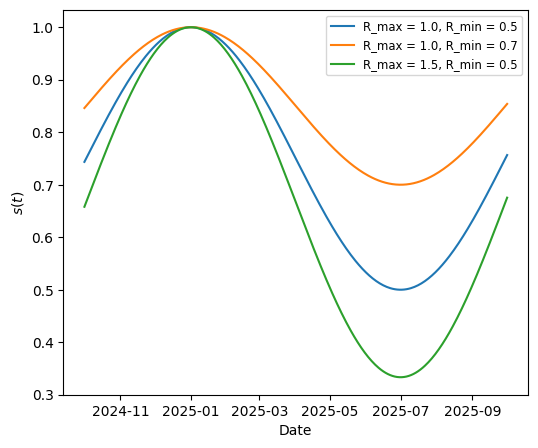

In [13]:
date_start = dt.date(2024, 10, 1)
date_stop = dt.date(2025, 10, 1)

fig, ax = plt.subplots(1,1, figsize=(6, 5))

# Parameter combinations: (R_min, R_max)
params = [(0.5, 1.0), (0.7, 1.0), (0.5, 1.5)]
for R_min, R_max in params:
    dates, st = get_seasonal_transmission_balcan(
        date_start=date_start,
        date_stop=date_stop,
        date_tmax=dt.date(2025, 1, 1), # peak transmission is January 1
        date_tmin=dt.date(2025, 7, 1), # lowest transmission is July 1
        R_min=R_min,
        R_max=R_max
    )
    ax.plot(dates, st, label=f"R_max = {R_max}, R_min = {R_min}")

ax.set_xlabel("Date")
ax.set_ylabel(r"$s(t)$")
ax.legend(fontsize="small")

To get the seasonally varying transmission rate $\beta_t$, we calculate

$$ \beta_t = \beta s(t).$$ 

As an illustrative example, we can look at the effect of using a seasonally varying transmission rate on the trajectory of an epidemic. For comparison, we can compare this to three scenarios where the transmission rate is held constant, but at different values:
1. $\beta^{\text{mean}} = \text{mean}(\beta_t)$: this tests the effect of having the same average transmission rate, but spread out evenly across the year
2. $\beta^{\text{max}} = \text{max}(\beta_t)$: this tests the effect of having the largest seasonal transmission rate for the whole year (should result in the biggest epidemic)
3. $\beta^{\text{min}} = \text{min}(\beta_t)$: this tests the effect of having the smallest seasonal transmission rate for the whole year (should result in the smallest epidemic)

In [14]:
beta = np.array(0.2)
tr_rate_seasonal = st * beta
tr_rate_mean = np.tile(np.mean(tr_rate_seasonal), len(tr_rate_seasonal))
tr_rate_max = np.tile(np.max(tr_rate_seasonal), len(tr_rate_seasonal))
tr_rate_min = np.tile(np.min(tr_rate_seasonal), len(tr_rate_seasonal))

<Axes: >

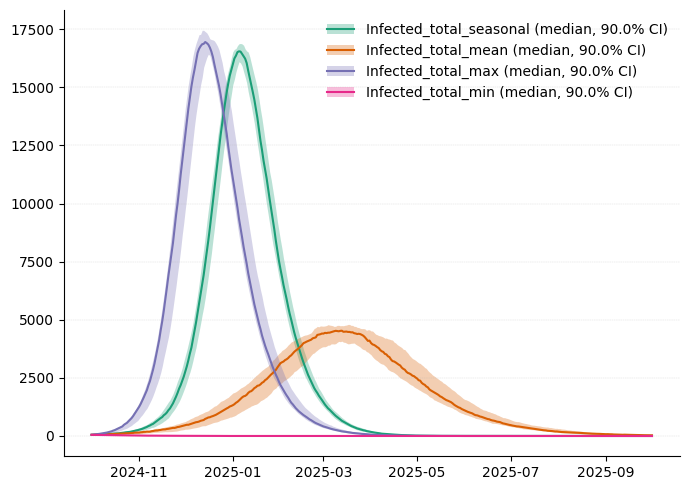

In [15]:
# Model configurations: (name, transmission_values)
configs = [
    ("seasonal", tr_rate_seasonal),
    ("mean", tr_rate_mean),
    ("max", tr_rate_max),
    ("min", tr_rate_min)
]

# Run simulations for all configurations
results = {}

for name, transmission_vals in configs:
    np.random.seed(19)
    model = load_predefined_model("SIR")
    model.add_parameter(parameter_name="transmission_rate", value=transmission_vals)
    
    results[name] = model.run_simulations(
        start_date=date_start, 
        end_date=date_stop,
        Nsim=25
    )

# Get quantiles and merge
dfs = {}
for name, result in results.items():
    df = result.get_quantiles_compartments()
    # Add suffix to all columns except merge keys
    for col in df.columns:
        if col not in ["date", "quantile"]:
            df = df.rename(columns={col: f"{col}_{name}"})
    dfs[name] = df

# Merge all DataFrames
merged_df = dfs["seasonal"]
for name in ["mean", "max", "min"]:
    merged_df = merged_df.merge(dfs[name], on=["date", "quantile"])

# Plot results
fig, ax = plt.subplots(figsize=(7, 5))
plot_quantiles(
    merged_df, 
    columns=["Infected_total_seasonal", "Infected_total_mean", "Infected_total_max", "Infected_total_min"], 
    legend_loc="upper right", 
    ax=ax
)

In this example, the effect of seasonality is important. Although the green (seasonal) and orange (constant mean) curves have the same average transmission rate across the whole year, they give markedly different epidemic trajectories. This is because the seasonality inflates the transmission rate during the winter months when the epidemic is taking off causing the green curve to grow quickly. Even though the transmission rate is lower in the summer months, this doesn't make so much difference because the epidemic has already occured. For contrast, if the transmission rate is set to the minimum, the epidemic doesn't even take off, and if it is set to the maximum it peaks even higher and faster than the seasonal scenario.